In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

# Image compression from scratch

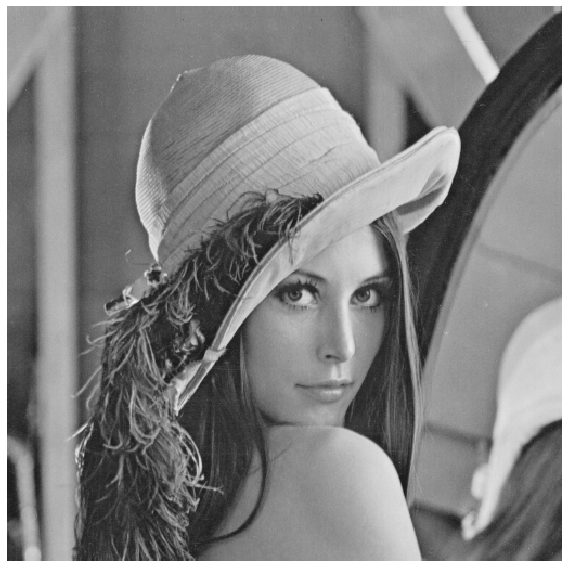

In [7]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import jpeg
from plotters import (
    load_image,
    plot_patch,
    plot_pixel_values
)


image_path = Path('..', 'images', 'lena512.bmp')
im = load_image(image_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(im, vmin=0, vmax=255, cmap='gray')
ax.axis('off')
plt.tight_layout()

# Image size

How much bits do we need to encode this image? (Only focussing on the pixel values.)

In [8]:
print(f'The pixel values range from {im.min()} to {im.max()}')

The pixel values range from 25.0 to 245.0


The (possible) pixel values are inbetween `0` and `255`. There for we need `8` bits to encode one pixel.

In [9]:
print(f"8 bits lets us encode {2 ** 8} integer values")

8 bits lets us encode 256 integer values


In [10]:
from operator import mul

bits_per_pixel = 8
image_size = lambda shape, bits_per_pixel: mul(*shape) * bits_per_pixel
print(f'We need {image_size(im.shape, bits_per_pixel)} bits to encode this image.')

We need 2097152 bits to encode this image.


# Image compresion

We see that the number of bits is a function of the `shape` and the `bits_per_pixel`. What if we reduce one of these?

This compression results in a compression of 37.5%.


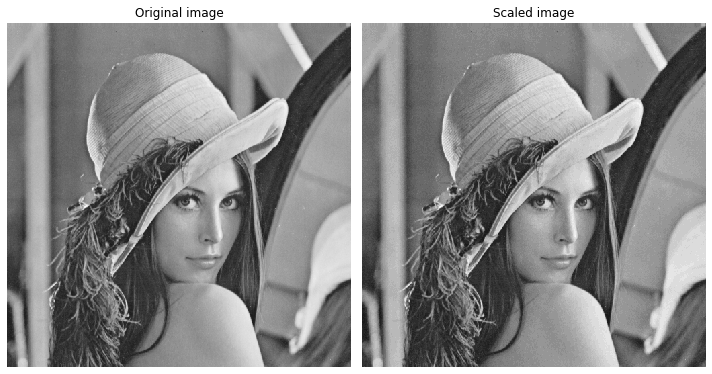

In [11]:
bits_per_pixel = 5
new_max_value = (2 ** bits_per_pixel) - 1
im_scaled = ((im / 255) * new_max_value).astype(int)

def plot_im_and_scaled_im(im, im_scaled, bits_per_pixel=8):
    fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(10, 8))
    ax_left.imshow(im, vmin=0, cmap='gray')
    ax_right.imshow(im_scaled, vmin=0, cmap='gray')
    for ax in (ax_left, ax_right):
        ax.axis('off')
    ax_left.set_title(f'Original image')
    ax_right.set_title(f'Scaled image')

    image_size_original = image_size(im.shape, 8)
    image_size_new = image_size(im_scaled.shape, bits_per_pixel)
    print(f'This compression results in a compression of {100 - 100 * image_size_new / image_size_original}%.')
    fig.tight_layout()
    return fig, (ax_left, ax_right)

plot_im_and_scaled_im(im, im_scaled, bits_per_pixel);

In [ ]:
ver_size, hor_size = [int(s / 2) for s in im.shape]
im_scaled = im[:ver_size, :hor_size]

plot_im_and_scaled_im(im, im_scaled);

# Upsampling

Instead of cropping the image we could take the average/median of a group of pixels.

In [ ]:
patch_size = 8

im_downsample = []
for y in range(0, im.shape[0], patch_size):
    for x in range(0, im.shape[0], patch_size):
        patch = im[y: y + patch_size, x: x + patch_size]
        val = np.mean(patch)
        im_downsample.append(val)

im_downsample = np.array(im_downsample).reshape([int(s / patch_size) for s in im.shape])
plot_im_and_scaled_im(im, im_downsample);

In [ ]:
def generate_patches(im, patch_size):
    for y in range(0, im.shape[0], patch_size):
        for x in range(0, im.shape[0], patch_size):
            yield im[y: y + patch_size, x: x + patch_size]

            
def downsample(im, func, patch_size):
    return np.array(
        [func(patch) for patch in generate_patches(im, patch_size)]
    ).reshape([int(s / patch_size) for s in im.shape])


im_downsample = downsample(im, np.mean, patch_size=4)
plot_im_and_scaled_im(im, im_downsample);

In [ ]:
im_downsample = downsample(im, np.median, 4)
plot_im_and_scaled_im(im, im_downsample);

In [ ]:
im_downsample = downsample(im, lambda patch: patch.min() + 0.5 * (patch.max() - patch.min()), 4)
plot_im_and_scaled_im(im, im_downsample);

# Filters

In [ ]:
import random
patches = list(generate_patches(im, patch_size=8))

In [ ]:
patch = random.choice(patches)
print(patch.max() - patch.min())
plot_filter(patch)

In [ ]:
hor_line_filter = np.array([
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
])
plot_filter(hor_line_filter)

In [ ]:
def apply_filter(patch, filter_):
    return (patch * filter_).sum()

In [ ]:
from functools import partial

im_downsample = downsample(im, partial(apply_filter, filter_=hor_line_filter), 8)
plot_im_and_scaled_im(im, im_downsample);

In [ ]:
im_downsample = downsample(im, partial(apply_filter, filter_=hor_line_filter.T), 8)
plot_im_and_scaled_im(im, im_downsample);

# Frequency filters

A.k.a cosine filters

In [ ]:
def discrete_cosine(freq, *, N=8):
    return np.cos(freq * (np.arange(N) + .5) * np.pi / N)


def normalisation_constant(freq):
    return 1 / np.sqrt(2) if freq == 0 else 1


def discrete_cosine_filter(freq_ver, freq_hor):
    dc_ver = discrete_cosine(freq_ver).reshape((-1, 1))
    dc_hor = discrete_cosine(freq_hor).reshape((1, -1))
    c = normalisation_constant(freq_ver) * normalisation_constant(freq_hor) 
    return .25 * c * (dc_ver @ dc_hor)


dc_filter = discrete_cosine_filter(4, 6)
plot_filter(dc_filter)

In [ ]:
def apply_filters(patch, *filters):
    return np.array([apply_filter(patch, filter_) for filter_ in filters])


def transform(im, filters_, *, patch_size=8):
    assert len(filters_) == patch_size * patch_size
    im_transformed = [
        apply_filters(patch, *filters_).reshape(patch_size, patch_size) 
        for patch in generate_patches(im, patch_size=8)
    ]
    
    n_hor_patches = int(im.shape[1] / patch_size)
    return np.vstack([
        np.hstack(im_transformed[y * n_hor_patches: (y + 1) * n_hor_patches])
        for y in range(int(im.shape[0] / patch_size))
    ])


dc_filters = [
    discrete_cosine_filter(x, y)
    for x in range(8)
    for y in range(8)
]

In [ ]:
plot_filter(dc_filters[-1])

In [ ]:
im_dc = transform(im - 128, dc_filters)

plot_im_and_scaled_im(im, im_dc);

In [ ]:
def inverse_discrete_cosine(pix, *, N=8):
    return np.cos(np.arange(N) * (pix + .5) * np.pi / N)


def inverse_discrete_cosine_filter(pix_ver, pix_hor):
    idc_ver = inverse_discrete_cosine(pix_ver).reshape((-1, 1))
    idc_hor = inverse_discrete_cosine(pix_hor).reshape((1, -1))
    c_ver = np.array([normalisation_constant(p) for p in range(8)]).reshape((-1, 1))
    c_hor = c_ver.copy().reshape((1, -1))
    c = c_ver @ c_hor
    return .25 * c * (idc_ver @ idc_hor)

filter_ = inverse_discrete_cosine_filter(0, 0)
plot_filter(filter_)

In [ ]:
np.hstack([patch])

In [ ]:
idc_filters = [
    inverse_discrete_cosine_filter(u, v)
    for u in range(8)
    for v in range(8)
]

im_back = transform(im_dc, idc_filters) + 128
plot_im_and_scaled_im(im, im_back);

In [ ]:
im_dc2

In [ ]:
from jpeg.pyjpeg import dct

In [ ]:
im_dc2 = dct(im)

In [ ]:
plot_pixel_values(im_dc)

In [ ]:
patches_dc = list(generate_patches((im_dc / 10).astype(int), 8))

In [ ]:
im_dc.max()

In [ ]:
plot_filter(random.choice(patches_dc))

In [ ]:
from jpeg.huffman import (
    int_to_bits,
    bits_to_int,
    zigzag_patch,
    izigzag_patch,
)

In [ ]:
bits_to_int('1111')

In [ ]:
2 ** 15

In [ ]:
np.arange(64).reshape(8, 8)

In [ ]:
zigzag_patch(np.arange(64).reshape(8, 8))

In [ ]:
bits_per_pixel

In [ ]:
def encode(sequence):
    bit_string = ''
    leading_zeros = 0
    for number in sequence:
        if number == 0:
            leading_zeros += 1
            continue
            
        while leading_zeros >= 15:
            bit_string += '11110000'
            leading_zeros -= 15
            
        # Half byte to encode leading zeros
        bit_string += int_to_bits(leading_zeros).zfill(4)
        
        number_in_bits = int_to_bits(abs(number))
        # Half byte to encode the bits needed to encode 
        # the value
        bit_string += int_to_bits(len(number_in_bits)).zfill(4)
        
        bit_string += '1' if number < 0 else '0'
        bit_string += number_in_bits
        
        leading_zeros = 0
        
    # End of block
    bit_string += '0' * 8
    
    return bit_string

In [ ]:
plot_filter(patch)

In [ ]:
patches = list(generate_patches(im_dc, 8))
patch = random.choice(patches).astype(int)
bit_string = encode(zigzag_patch(patch))
plot_filter(patch)

In [ ]:
im.shape

In [ ]:
def decode(bit_string, *, remainder=False):
    patch = np.zeros(64, dtype=int)
    
    pos = 0
    patch_idx = 0
    while True:
        leading_zeros = bits_to_int(bit_string[pos: pos + 4])
        bits_to_encode_val = bits_to_int(bit_string[pos + 4: pos + 8])
        
        # End of block
        if leading_zeros == 0 and bits_to_encode_val == 0:
            pos += 8
            break
            
        # 15 zeros
        if leading_zeros == 15 and bits_to_encode_val == 0:
            patch_idx += 15
            pos += 8
            continue
            
            
        sign = -1 if bit_string[pos + 8] == '1' else 1
        number_in_bits = bit_string[pos + 9: pos + 9 + bits_to_encode_val]
        
        patch_idx += leading_zeros
        patch[patch_idx] = sign * bits_to_int(number_in_bits)
        patch_idx += 1
        
        pos += 8 + 1 + bits_to_encode_val
        
    if remainder:
        return patch, bit_string[pos:]
    else:
        return patch

out = izigzag_patch(decode(bit_string))
plot_filter(out)

In [ ]:
def compress(im, Q=1):

    im = im - 128

    dc_filters = [
        discrete_cosine_filter(x, y)
        for x in range(8)
        for y in range(8)
    ]
    
    dct = transform(im, dc_filters)
    
    bit_string = ''.join(
        encode(zigzag_patch((patch / Q).astype(int)))
        for patch in generate_patches(dct, patch_size=8)
    )
    return bit_string, dct

Q = 1
bit_string, im_dc1 = compress(im, Q=Q)
len(bit_string)

In [ ]:
from jpeg.quantization import quantization_50

plot_filter(quantization_50)

In [ ]:
def decompress(bit_string, Q=1):
    
    im_transformed = []
    while len(bit_string) > 0:
        patch, bit_string = decode(bit_string, remainder=True)
        im_transformed.append(izigzag_patch(patch) * Q)
    
    # TODO: im.shape is unknown should be in the bit string also
    patch_size = 8
    n_hor_patches = int(im.shape[1] / patch_size)
    im_dc = np.vstack([
        np.hstack(im_transformed[y * n_hor_patches: (y + 1) * n_hor_patches])
        for y in range(int(im.shape[0] / patch_size))
    ])
    
    idc_filters = [
        inverse_discrete_cosine_filter(u, v)
        for u in range(8)
        for v in range(8)
    ]

    im_back = transform(im_dc, idc_filters) + 128
    
    return im_back.astype(int), im_dc


im_back, im_dc2 = decompress(bit_string, Q=Q)
plot_im_and_scaled_im(im, im_back);

In [ ]:
len(bit_string) / image_size(im.shape, 8)

In [ ]:
np.testing.assert_almost_equal(im_dc1.astype(int), im_dc2)